# Visualizing with slideflow

In [ ]:
import os
import slideflow as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

# Create wsi objects that represent the slides, ROIs, and labels
#AF110F
wsi_grayson = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/TAM_then_4NQO/AF110F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson/AF110F.csv"
)

wsi_anna = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/TAM_then_4NQO/AF110F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna/AF110F.csv"
)

# Generate thumbnails without ROI overlays
thumb_grayson = wsi_grayson.thumb(width=1024, rois=False)
thumb_anna = wsi_anna.thumb(width=1024, rois=False)

# Calculate scaling factor (assuming both slides have the same original dimensions)
orig_width, _ = wsi_grayson.dimensions
scale = thumb_grayson.width / orig_width

# Define a simple color mapping
color_map = {
    'dysplasia': 'red',
    'mild': 'orange',
    'moderate': 'yellow',
    'severe': 'purple',
    "benign": "blue",
    "invasive carcinoma": "green"
}

def overlay_rois(ax, wsi_obj):
    # Loop through each ROI and overlay a polygon
    for roi in wsi_obj.rois:
        # Determine if the ROI geometry is a Polygon or MultiPolygon
        if roi.poly.geom_type == "Polygon":
            polygons = [roi.poly]
        elif roi.poly.geom_type == "MultiPolygon":
            polygons = list(roi.poly.geoms)
        else:
            print(f"Unknown geometry type: {roi.poly.geom_type} for ROI with label {roi.label}")
            continue
         # Use the same label for all sub-polygons
        label = roi.label.lower() if roi.label else "unknown"
        color = color_map.get(label, "pink")

        for poly in polygons:
            # Scale the polygon coordinates to match the thumbnail dimensions.
            poly_coords = np.array(poly.exterior.coords) * scale
            
            # Create and add the polygon patch to the axis.
            patch = MplPolygon(poly_coords, closed=True, edgecolor=color, fill=False, linewidth=2)
            ax.add_patch(patch)
            

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Grayson's overlay
ax1.imshow(thumb_grayson)
overlay_rois(ax1, wsi_grayson)
ax1.set_title("Grayson's Annotations")

# Anna's overlay
ax2.imshow(thumb_anna)
overlay_rois(ax2, wsi_anna)
ax2.set_title("Anna's Annotations")

# Add legend
legend_elements = [plt.Line2D([0], [0], color=color, label=label.capitalize(), linewidth=2)
                  for label, color in color_map.items()]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))

plt.show()


# Qualitative analysis of 24 slides

In [1]:
# Create dictionary that maps slide name to path (since slides are stored in two different directories)
import os

slides_dir_1 = "/home/joeychan/labshare/SLIDES/PDCD10/TAM_then_4NQO"
slides_dir_2 = "/home/joeychan/labshare/SLIDES/PDCD10/4NQO_then_TAM"

# Collect all .svs files in both directories
svs_map = {}

for d in [slides_dir_1, slides_dir_2]:
    #iterating through each file in the current directory (d is a string path but os.listdir returns a list of files in the directory)
    for fname in os.listdir(d):
        if fname.endswith(".svs"):
            base_name = fname.replace(".svs", "")
            svs_map[base_name] = os.path.join(d, fname)

In [ ]:
import os
import slideflow as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon, MultiPolygon

#directories for the annotation CSV files
grayson_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson"
anna_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna"

# Directory where comparison images will be saved
output_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/roi_comparisons"
os.makedirs(output_dir, exist_ok=True)

# ---------------------------
# STEP 3: Define a helper function to overlay ROIs on a given axis.
# ---------------------------

def overlay_rois(ax, wsi_obj, scale, color_map, area_threshold=0):

    for roi in wsi_obj.rois:
        # Determine if the ROI geometry is a Polygon or MultiPolygon
        if roi.poly.geom_type == "Polygon":
            polygons = [roi.poly]
        elif roi.poly.geom_type == "MultiPolygon":
            polygons = list(roi.poly.geoms)
        else:
            print(f"Unknown geometry type: {roi.poly.geom_type} for ROI with label {roi.label}")
            continue
        
        # Use the same label for all sub-polygons
        label = roi.label.lower() if roi.label else "unknown"
        #change any label that mentions a grade to dysplasia
        if label in ['mild', 'moderate', 'severe']:
            label = 'dysplasia'
        color = color_map.get(label, "green")
        
        for poly in polygons:
            # Optionally filter out small polygons based on area
            if poly.area < area_threshold:
                continue
            
            # Scale the polygon coordinates to match the thumbnail dimensions.
            poly_coords = np.array(poly.exterior.coords) * scale
            
            # Create and add the polygon patch to the axis.
            patch = MplPolygon(poly_coords, closed=True, edgecolor=color, fill=False, linewidth=2)
            ax.add_patch(patch)
            
            # Compute centroid for labeling.
            # centroid = poly_coords.mean(axis=0)
            # ax.text(centroid[0], centroid[1], label, fontsize=8, color=color)


# Define a simple color mapping for different labels.
color_map = {
    "dysplasia": "red",
    "mild": "orange",
    "moderate": "yellow",
    "severe": "purple",
    "benign": "blue"
}

# ---------------------------
# STEP 4: Loop over each CSV in Grayson's directory to build comparisons.
# ---------------------------

for csv_file in os.listdir(grayson_dir):
    if csv_file.endswith(".csv"):
        #print "current csv file"
        print("current csv file: ", csv_file)
        # Extract the base name (e.g., "AF102F" from "AF102F.csv")
        base_name = csv_file.replace(".csv", "")
        
        # Look up the matching SVS file in the dictionary.
        if base_name not in svs_map:
            print(f"No .svs file found for {base_name}, skipping.")
            continue
        #Will use this path for both Grayson and Anna WSI objects 
        svs_path = svs_map[base_name]
        
        # Build full paths for the annotation CSV files for both pathologists.
        grayson_csv = os.path.join(grayson_dir, csv_file)
        anna_csv = os.path.join(anna_dir, csv_file)  # assuming the same filename
        
        # Check if Anna's CSV exists; if not, skip this slide.
        if not os.path.exists(anna_csv):
            print(f"Anna's CSV for {base_name} not found, skipping.")
            continue
        
        # Create WSI objects for Grayson and Anna using the same slide (svs_path)
        wsi_grayson = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=grayson_csv)
        wsi_anna = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=anna_csv)
        
        # Generate a thumbnail image without ROI overlays.
        thumb_grayson = wsi_grayson.thumb(width=1024, rois=False)
        thumb_anna = wsi_anna.thumb(width=1024, rois=False)
        
        # Calculate the scaling factor between original slide dimensions and thumbnail.
        orig_width, _ = wsi_grayson.dimensions  # assume both have same dimensions
        scale = thumb_grayson.width / orig_width
        
        # Create a side-by-side figure to compare the overlays.
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Display Grayson's thumbnail and overlay his ROIs.
        ax1.imshow(thumb_grayson)
        overlay_rois(ax1, wsi_grayson, scale, color_map)
        ax1.set_title(f"{base_name} - Grayson")
        
        # Display Anna's thumbnail and overlay her ROIs.
        ax2.imshow(thumb_anna)
        overlay_rois(ax2, wsi_anna, scale, color_map)
        ax2.set_title(f"{base_name} - Anna")
        
        # Save the comparison figure.
        outpath = os.path.join(output_dir, f"{base_name}_comparison.png")
        plt.savefig(outpath, dpi=150)
        plt.close(fig)
        
        print(f"Saved comparison image for {base_name} to {outpath}")



In [3]:
import os
from IPython.display import Image, display

# Define the output directory where the PNGs are stored.
output_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/roi_comparisons"

# Get a sorted list of all PNG files in the directory.
png_files = sorted([f for f in os.listdir(output_dir) if f.endswith(".png")])

# Loop over the files and display each one individually.
for png_file in png_files:
    file_path = os.path.join(output_dir, png_file)
    print(png_file)  # Optionally print the file name.
    display(Image(filename=file_path))


# Quanitative Analysis

In [2]:
from shapely.ops import unary_union
from shapely.geometry import GeometryCollection

#Assuming that the annotations cover the entire epithelium, so combine into one 
# object to get total area

def get_total_union(wsi_obj, area_threshold=0):
    """
    Combine all ROIs in the WSI object into a single geometry.
    
    Parameters:
      - wsi_obj: A slideflow.WSI object with ROI annotations.
      - area_threshold: (Optional) Only include polygons with area >= area_threshold.
    
    Returns:
      - A Shapely geometry (Polygon or MultiPolygon) representing the union of all ROIs,
        or an empty GeometryCollection if none are found.
    """
    polygons = []
    for roi in wsi_obj.rois:
        if roi.poly.geom_type == "Polygon":
            if roi.poly.area >= area_threshold:
                polygons.append(roi.poly)
        elif roi.poly.geom_type == "MultiPolygon":
            for subpoly in roi.poly.geoms:
                if subpoly.area >= area_threshold:
                    polygons.append(subpoly)
        else:
            print(f"Unknown geometry type: {roi.poly.geom_type} for ROI with label {roi.label}")
    
    if polygons:
        return unary_union(polygons)
    else:
        return GeometryCollection()




In [3]:
#Getting just the dysplasia ROIs combined to easily get area, etc

def get_dysplasia_union(wsi_obj, dysplasia_labels, area_threshold=0):
    """
    Combine only those ROIs in the WSI object that are labeled as dysplasia into one geometry.
    
    Parameters:
      - wsi_obj: A slideflow.WSI object with ROI annotations.
      - dysplasia_labels: A set of label strings that count as dysplasia (e.g., {"mild", "moderate", "severe", "dysplasia"}).
      - area_threshold: (Optional) Only include polygons with area >= area_threshold.
    
    Returns:
      - A Shapely geometry representing the union of dysplasia ROIs,
        or an empty geometry if none are found.
    """
    polygons = []
    for roi in wsi_obj.rois:
        label = roi.label.lower() if roi.label else "unknown"
        if label in dysplasia_labels:
            if roi.poly.geom_type == "Polygon":
                if roi.poly.area >= area_threshold:
                    polygons.append(roi.poly)
            elif roi.poly.geom_type == "MultiPolygon":
                for subpoly in roi.poly.geoms:
                    if subpoly.area >= area_threshold:
                        polygons.append(subpoly)
            else:
                print(f"Skipping unknown geometry type: {roi.poly.geom_type}")
    
    if polygons:
        return unary_union(polygons)
    else:
        return GeometryCollection()



In [4]:

#Note that we are inputting objects that represents union of the 
#DYSPLASIA ROIS. When you call intersection, it can find the area where they overlap
#using the boundary and interior points. The union object is not just an area, it retains 
#the BOUNDARY points. 
def compute_overlap_metrics(union_A, union_B):
    """
    Given two Shapely geometries (unions of dysplasia annotations from two pathologists),
    compute the overlap metrics: intersection area, IoU, and Dice coefficient.
    
    Parameters:
      - union_A: Shapely geometry for pathologist A's dysplasia.
      - union_B: Shapely geometry for pathologist B's dysplasia.
      
    Returns:
      - intersection_area: Area where both annotations overlap.
      - iou: Intersection over Union metric.
      - dice: Dice coefficient.
    """
    # Compute the intersection area between the two unions.
    intersection_area = union_A.intersection(union_B).area
    
    # Compute the union of both annotations (for IoU).
    #This is just Area A + B - intersection area
    combined_union_area = union_A.union(union_B).area
    
    # Compute IoU (Jaccard Index). Avoid division by zero.
    iou = intersection_area / combined_union_area if combined_union_area > 0 else 0
    
    # Compute Dice coefficient. Avoid division by zero.
    total_area = union_A.area + union_B.area
    dice = (2 * intersection_area) / total_area if total_area > 0 else 0
    
    return intersection_area, iou, dice

In [7]:
# Defining the WSI objects
import slideflow as sf

wsi_grayson = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/4NQO_then_TAM/AG987F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson/AG987F.csv"
)

wsi_anna = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/4NQO_then_TAM/AG987F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna/AG987F.csv"
)

In [ ]:
#Using the functions to get the percentage of dysplasia each pathologist labelled 
dysplasia_labels = {"dysplasia", "mild", "moderate", "severe"}

#Get pixels per micrion for both (should be same since same slide)
mpp_grayson = wsi_grayson.mpp
mpp_anna = wsi_anna.mpp


# Get the union of all ROIs (the total epithelium, assuming the annotations cover it)
total_union_grayson = get_total_union(wsi_grayson, area_threshold=0)
# Get the union of dysplasia ROIs only
dys_union_grayson = get_dysplasia_union(wsi_grayson, dysplasia_labels, area_threshold=0)

#Anna's annotations
total_union_anna = get_total_union(wsi_anna, area_threshold=0)
dys_union_anna = get_dysplasia_union(wsi_anna, dysplasia_labels, area_threshold=0)

# Compute grayson areas in square microns
total_area_grayson = total_union_grayson.area
#convert to square microns  
total_area_grayson = total_area_grayson * (mpp_grayson**2)

dys_area_grayson = dys_union_grayson.area
#convert to square microns
dys_area_grayson = dys_area_grayson * (mpp_grayson**2)


#compute anna's areas in square microns
total_area_anna = total_union_anna.area
#convert to square microns
total_area_anna = total_area_anna * (mpp_anna**2)

dys_area_anna = dys_union_anna.area
#convert to square microns
dys_area_anna = dys_area_anna * (mpp_anna**2)

# Compute the percentage of the epithelium labeled as dysplasia

dys_percentage_grayson = (dys_area_grayson / total_area_grayson) * 100
dys_percentage_anna = (dys_area_anna / total_area_anna) * 100

intersection_area, iou, dice = compute_overlap_metrics(dys_union_grayson, dys_union_anna)
#convert intersection area to square microns
intersection_area = intersection_area * (mpp_grayson**2)



print(f"Total annotated area grayson: {total_area_grayson}")
print(f"Dysplasia area grayson: {dys_area_grayson}")
print(f"Percentage dysplasia grayson: {dys_percentage_grayson:.2f}%")

print(f"Total annotated area anna: {total_area_anna}")
print(f"Dysplasia area anna: {dys_area_anna}")
print(f"Percentage dysplasia anna: {dys_percentage_anna:.2f}%")


print("Intersection Area:", intersection_area)
#Both dice and IOU report the overlap between the two pathologists. Iou measure overlap relative to the total
#UNIQUE area covered by both regions. Dice uses the intersection and adds the area of the two regions. 
#So if there is little overlap between the two regions, IoU denominator is very similar to dice denominator since 
#subtracting the intersction only subtracts a small value from the total area. However, dice weighs the intersection 2x as much, 
#so DICE would be higher overall. 
print("IoU (Jaccard Index):", iou)
print("Dice Coefficient:", dice)


In [ ]:
#compute more than just overlap. 

#Percentage of Grayson's dysplasia that is also annotated by Anna
#(Tells us how much Anna agrees with Grayson's annotations)
percentage_grayson_covered = (intersection_area / dys_area_grayson) * 100
print(f"Percentage of Grayson's dysplasia that is also annotated by Anna: {percentage_grayson_covered:.2f}%")

#Percentage of Anna's dysplasia that is also annotated by Grayson
#(Tells us how much Grayson agrees with Anna's annotations)
percentage_anna_covered = (intersection_area / dys_area_anna) * 100
print(f"Percentage of Anna's dysplasia that is also annotated by Grayson: {percentage_anna_covered:.2f}%")





# Obtaining dysplasia differences based on genotpye

In [ ]:
#Use existing function to get the union of the total and dysplasia ROIS, then we get the dysplasia area
#and the percentage of the dysplasia that is also in the total for each csv for anna and grayon. Then 
#we put results into a new dataframe that also stores genotype. Then we plot the results. 
import pandas as pd
import matplotlib.pyplot as plt 
import slideflow as sf
import os

#load df that contains genotype information 
genotype_df = pd.read_csv("/home/joeychan/cancer_project/Cancer_Project_2025/tracking.csv")
#create output dataframe
results = pd.DataFrame(columns=["slide", "total_area_grayson", "dys_area_grayson", "dys_percentage_grayson", "genotype"])

dysplasia_labels = {"dysplasia", "mild", "moderate", "severe"}

#replace grayson directory depending on which experiment you are looking at 
grayson_dir = "/home/joeychan/cancer_project/Cancer_Project_2025/Grayson/Exp2"

for csv_file in os.listdir(grayson_dir):
    if csv_file.endswith(".csv"):
        #print "current csv file"
        print("current csv file: ", csv_file)
        # Extract the base name (e.g., "AF102F" from "AF102F.csv")
        base_name = csv_file.replace(".csv", "")
        
        # Look up the matching SVS file in the dictionary.
        if base_name not in svs_map:
            print(f"No .svs file found for {base_name}, skipping.")
            continue
        #Will use this path for both Grayson and Anna WSI objects 
        svs_path = svs_map[base_name]

        #use base name to get genotype
        #skip if base name doesn't match any entry in the slide column of the genotype df
        if base_name not in genotype_df["slide"].values:
            print(f"No genotype information found for {base_name}, skipping.")
            continue
        genotype = genotype_df.loc[genotype_df["slide"] == base_name, "genotype"].values[0]
        
        # Build full paths for the annotation CSV files for both pathologists.
        grayson_csv = os.path.join(grayson_dir, csv_file)
        
        
        # Create WSI object for current slide
        wsi_grayson = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=grayson_csv)
    
         #get pixels to micron ratio
        mpp_grayson = wsi_grayson.mpp

        #Call functions to get union of total and dysplasia ROIS
        total_union_grayson = get_total_union(wsi_grayson, area_threshold=0)
        dys_union_grayson = get_dysplasia_union(wsi_grayson, dysplasia_labels, area_threshold=0)

        #Get area and convert from pixels to square microns 
        total_area_grayson = total_union_grayson.area
        total_area_grayson = total_area_grayson * (mpp_grayson**2)

        dys_area_grayson = dys_union_grayson.area
        dys_area_grayson = dys_area_grayson * (mpp_grayson**2)

        #Get percentage of dysplasia that is also in the total
        dys_percentage_grayson = (dys_area_grayson / total_area_grayson) * 100

        #output to dataframe 
        new_result = pd.DataFrame({
            "slide": [base_name],
            "total_area_grayson": [total_area_grayson],
            "dys_area_grayson": [dys_area_grayson],
            "dys_percentage_grayson": [dys_percentage_grayson],
            "genotype": [genotype]
        })

        #add new result to results dataframe
        results = pd.concat([results, new_result], ignore_index=True)

In [ ]:
results["genotype"].value_counts()

In [ ]:
#see how many genotpyes are F/F vs F/+
results['dys_percentage_grayson'][results['genotype'] == 'F/F'].describe()


In [ ]:
results['dys_percentage_grayson'][results['genotype'] == 'F/+'].describe()

In [ ]:
#make boxplot of dysplasia percentage by genotype
import seaborn as sns
import matplotlib.pyplot as plt

#drop rows where area is zero
results = results[results["total_area_grayson"] > 0]
#make boxplot of dysplasia percentage by genotype
plt.figure(figsize=(6, 6))
sns.boxplot(x='genotype', y='dys_percentage_grayson', data=results)
sns.stripplot(x='genotype', y='dys_percentage_grayson', data=results, 
              color='black', alpha=0.5)  # optional jittered points

plt.title("Dysplasia Percentage by Genotype (Experiment 2, Grayson)")
plt.ylabel("Dysplasia Percentage (%)")
plt.show()

In [ ]:
#load df that contains genotype information 
genotype_df = pd.read_csv("/home/joeychan/cancer_project/Cancer_Project_2025/tracking.csv")
#create output dataframe
results2 = pd.DataFrame(columns=["slide", "total_area_anna", "dys_area_anna", "dys_percentage_anna", "genotype"])

dysplasia_labels = {"dysplasia", "mild", "moderate", "severe"}



#replace grayson directory depending on which experiment you are looking at 
anna_dir = "/home/joeychan/cancer_project/Cancer_Project_2025/Anna/exp3"

for csv_file in os.listdir(anna_dir):
    if csv_file.endswith(".csv"):
        #print "current csv file"
        print("current csv file: ", csv_file)
        # Extract the base name (e.g., "AF102F" from "AF102F.csv")
        base_name = csv_file.replace(".csv", "")
        
        # Look up the matching SVS file in the dictionary.
        if base_name not in svs_map:
            print(f"No .svs file found for {base_name}, skipping.")
            continue

        if base_name == "AG039F":
            continue
        #Will use this path for both Grayson and Anna WSI objects 
        svs_path = svs_map[base_name]
        #skip this svs path cause it cannot load

        #use base name to get genotype
        #skip if base name doesn't match any entry in the slide column of the genotype df
        if base_name not in genotype_df["slide"].values:
            print(f"No genotype information found for {base_name}, skipping.")
            continue
        genotype = genotype_df.loc[genotype_df["slide"] == base_name, "genotype"].values[0]
        
        # Build full paths for the annotation CSV files for both pathologists.
        anna_csv = os.path.join(anna_dir, csv_file)
        
        
        # Create WSI object for current slide
        wsi_anna = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=anna_csv)
    
         #get pixels to micron ratio
        mpp_anna = wsi_anna.mpp

        #Call functions to get union of total and dysplasia ROIS
        total_union_anna = get_total_union(wsi_anna, area_threshold=0)
        dys_union_anna = get_dysplasia_union(wsi_anna, dysplasia_labels, area_threshold=0)

        #Get area and convert from pixels to square microns 
        total_area_anna = total_union_anna.area
        total_area_anna = total_area_anna * (mpp_anna**2)

        dys_area_anna = dys_union_anna.area
        dys_area_anna = dys_area_anna * (mpp_anna**2)

        #Get percentage of dysplasia that is also in the total
        dys_percentage_anna = (dys_area_anna / total_area_anna) * 100

        #output to dataframe 
        new_result2 = pd.DataFrame({
            "slide": [base_name],
            "total_area_anna": [total_area_anna],
            "dys_area_anna": [dys_area_anna],
            "dys_percentage_anna": [dys_percentage_anna],
            "genotype": [genotype]
        })

        #add new result to results dataframe
        results2 = pd.concat([results2, new_result2], ignore_index=True)

In [ ]:
print(results2)

In [ ]:
#make boxplot of dysplasia percentage by genotype
import seaborn as sns
import matplotlib.pyplot as plt

#drop rows where area is zero
results2 = results2[results2["total_area_anna"] > 0]
#make boxplot of dysplasia percentage by genotype
plt.figure(figsize=(6, 6))
sns.boxplot(x='genotype', y='dys_percentage_anna', data=results2)
sns.stripplot(x='genotype', y='dys_percentage_anna', data=results2, 
              color='black', alpha=0.5)  # optional jittered points

plt.title("Dysplasia Percentage by Genotype (Experiment 3, Anna)")
plt.ylabel("Dysplasia Percentage (%)")
plt.show()

# Getting Graph of IOUs

In [ ]:
import pandas as pd
import slideflow as sf

#create output datafrae that will store the iou for each slide
results = pd.DataFrame(columns=["slide", "iou"])

dysplasia_labels = {"dysplasia", "mild", "moderate", "severe"}

grayson_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson"
anna_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna"

#grayson directory has the slides they BOTH labeled 
for csv_file in os.listdir(grayson_dir):
    if csv_file.endswith(".csv"):
        print("current csv file: ", csv_file)
        base_name = csv_file.replace(".csv", "")

        if base_name not in svs_map:
            print(f"No .svs file found for {base_name}, skipping.")
            continue
        
        svs_path = svs_map[base_name]
        grayson_csv = os.path.join(grayson_dir, csv_file)
        anna_csv =  os.path.join(anna_dir, csv_file)

        wsi_grayson = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=grayson_csv)
        #if Anna's object doesn't load, skip this slide
        try:
            wsi_anna = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=anna_csv)
        except:
            print(f"Anna Object didn't load for {base_name}, skipping.")
            continue

        dys_union_grayson = get_dysplasia_union(wsi_grayson, dysplasia_labels, area_threshold=0)
        dys_union_anna = get_dysplasia_union(wsi_anna, dysplasia_labels, area_threshold=0)

        intersection_area, iou, dice = compute_overlap_metrics(dys_union_grayson, dys_union_anna)

        #output to dataframe 
        new_result = pd.DataFrame({
            "slide": [base_name],
            "iou": [iou]
        })

        #add new result to results dataframe
        results = pd.concat([results, new_result], ignore_index=True)

In [ ]:
#checked and saw that zero meant that there was no dysplasia labelled, so we will drop the zeros
print(results)


In [ ]:
results = results[results["iou"] != 0]
print(results)


In [ ]:
overlapping_slides = results["slide"].tolist()
print(overlapping_slides)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Sort the results by IOU value
results_sorted = results.sort_values('iou', ascending=True)

# Create a figure for the plot
plt.figure(figsize=(10, 6))  # Doubled width to 20

# Create a horizontal bar graph for slides and iou
sns.barplot(y='slide', x='iou', data=results_sorted, palette='viridis')

# Set the title and labels
plt.title("Distribution of IOU Across Labelled Slides")
plt.ylabel("Slide")
plt.xlabel("IOU")

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


# Loading Data for Centerline Processing

In [ ]:
#alternative method for loading the data
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


# Load the CSV file
csv_path = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson/AF110F.csv"
df = pd.read_csv(csv_path)

# Group points by ROI name
roi_polygons = {}
#note that groupby is grouping by the roi_name column
#note that group is just a subset of the dataframe corresponding to the roi_name
for roi_name, group in df.groupby("roi_name"):
    #taking the two series of x and y coordinates and zipping them together. Zip needs two interables and makes tuples
    points = list(zip(group["x_base"], group["y_base"]))  # Convert to (x, y) coordinates
    #adding to the dictionary
    roi_polygons[roi_name] = Polygon(points)  # Create Shapely Polygon

#pritning dictionary here
for roi, poly in roi_polygons.items():
    print(f"ROI {roi}: Area = {poly.area}, Length = {poly.length}")


# Visualizing Voroni Graphs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_2"]  # Replace with different ROI if needed

# Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Graph")
plt.show()

#get the vertices that define the regions
vor_vertices = vor.vertices


# Graph based with additional changes

Tried percetile based trimming and it works really well! Before ends of the graph based method were not representative of the centerline. Trimming seems to be a simpler solution rather than filtering based on width, angle, etc. 10% seems to be a good threshold. 

Note: can take a while because after finding terminal nodes, we are using a doule for loop. Must be a way to optimize this since there is some redudancy. IF you iterate through a terminal node and its distance to all other terminal nodes, you are going to repreat some measurements when you run on another node...

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# --------------------------
# 1) Percentile-based Trim
# --------------------------
def trim_ends_by_percentile(centerline, polygon, low_pct=10):
    """
    Trims centerline points whose distance to polygon boundary
    is below the `low_pct` percentile of all distances.
    This automatically adapts to different ROI shapes & sizes.
    """
    if not centerline or not len(centerline.coords):
        return None

    coords = list(centerline.coords)

    # 1. Compute distance to boundary for all points
    #same size as the coords list and first entry here corresponds to the distance of the first point in coords to the boundary, etc. 
    #This allows us to zip the two lists together and then filter based on the distance later on
    dists = [polygon.exterior.distance(Point(pt)) for pt in coords]

    # 2. Determine cutoff using low percentile
    # so if it's 10 it means cutoff is 10th percentile of distances 
    # (idea is that the points with the smallest distances to boundary are the "tails" we noticed that aren't part of the true centerline )
    cutoff = np.percentile(dists, low_pct)

    # 3. Keep only points with distance >= cutoff
    new_coords = [pt for pt, dist in zip(coords, dists) if dist >= cutoff]

    # 4. Rebuild centerline
    if len(new_coords) < 2:
        return None
    return LineString(new_coords)

# --------------------------
# 2) Your Existing Voronoi + Graph Steps
# --------------------------

# For example, choose an ROI to process
roi_name = "ROI_2"
roi_polygon = roi_polygons[roi_name]

# Extract boundary points
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi
vor = Voronoi(boundary_coords)

# Filter Voronoi edges inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Merge edges into a single geometry
medial_axis = unary_union(valid_lines)

# Convert to graph
def medial_axis_to_graph(medial_axis):
    G = nx.Graph()
    if isinstance(medial_axis, MultiLineString):
        for line in medial_axis.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                #the weight is the distance between the two points
                seg_length = Point(coords[i]).distance(Point(coords[i+1]))
                G.add_edge(coords[i], coords[i+1], weight=seg_length)
    elif isinstance(medial_axis, LineString):
        coords = list(medial_axis.coords)
        for i in range(len(coords) - 1):
            seg_length = Point(coords[i]).distance(Point(coords[i+1]))
            G.add_edge(coords[i], coords[i+1], weight=seg_length)
    return G

G = medial_axis_to_graph(medial_axis)

# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Find the longest path among terminal nodes
def find_longest_path(G_largest):
    #iterating through all nodes and keeping the ones with degree 1 (terminal nodes)
    print("finding terminal nodes")
    terminal_nodes = [n for n in G_largest.nodes if G_largest.degree[n] == 1]
    #print number of terminal nodes
    print(f"number of terminal nodes: {len(terminal_nodes)}")
    if len(terminal_nodes) < 2:
        return None

    max_length = 0
    best_pair = None
    #double loop tof find distance between each pair of terminal nodes
    #two terminal nodes that are furthest apart should represent the centerline
    print("finding longest path")
    for i in range(len(terminal_nodes)):
        for j in range(i+1, len(terminal_nodes)):
            try:
                path_length = nx.shortest_path_length(
                    G_largest, terminal_nodes[i], terminal_nodes[j], weight="weight"
                )
                if path_length > max_length:
                    max_length = path_length
                    #update best pair to this one with the longest distance
                    best_pair = (terminal_nodes[i], terminal_nodes[j])
            except nx.NetworkXNoPath:
                pass

    if not best_pair:
        return None
    #returns the longest path between the two terminal nodes
    return nx.shortest_path(G_largest, source=best_pair[0], target=best_pair[1], weight="weight")

longest_path = find_longest_path(G_largest)
if longest_path:
    centerline = LineString(longest_path)
else:
    centerline = None

# --------------------------
# 3) Apply Percentile-based Trim
# --------------------------
#centerline is longest path but may have tails--->trim the line to get the true centerline
if centerline:
    # e.g., low_pct=10 means removing points in the lower 10% boundary distance
    centerline = trim_ends_by_percentile(centerline, roi_polygon, low_pct=10)

# --------------------------
# 4) Visualization
# --------------------------
if centerline and len(centerline.coords) > 1:
    print(f"[{roi_name}] Centerline Length (after percentile trim):", centerline.length)

fig, ax = plt.subplots(figsize=(8, 6))
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

if centerline and len(centerline.coords) > 1:
    cx, cy = centerline.xy
    ax.plot(cx, cy, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Final Centerline with Percentile-based Trimming ({roi_name})")
plt.legend()
plt.show()


# Graph based with changes made into functions

In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# --------------------------
# 1) Percentile-based Trim
# --------------------------
def trim_ends_by_percentile(centerline, polygon, low_pct=10):
    """
    Trims centerline points whose distance to polygon boundary
    is below the `low_pct` percentile of all distances.
    This automatically adapts to different ROI shapes & sizes.
    """
    if not centerline or not len(centerline.coords):
        return None

    coords = list(centerline.coords)

    # 1. Compute distance to boundary for all points
    #same size as the coords list and first entry here corresponds to the distance of the first point in coords to the boundary, etc. 
    #This allows us to ip the two lists together and then filter based on the distance later on
    dists = [polygon.exterior.distance(Point(pt)) for pt in coords]

    # 2. Determine cutoff using low percentile
    # so if it's 10 it means cutoff is 10th percentile of distances 
    # (idea is that the points with the smallest distances to boundary are the "tails" we noticed that aren't part of the true centerline )
    cutoff = np.percentile(dists, low_pct)

    # 3. Keep only points with distance >= cutoff
    new_coords = [pt for pt, dist in zip(coords, dists) if dist >= cutoff]

    # 4. Rebuild centerline
    if len(new_coords) < 2:
        return None
    return LineString(new_coords)

In [26]:
# Convert to graph
def medial_axis_to_graph(medial_axis):
    G = nx.Graph()
    if isinstance(medial_axis, MultiLineString):
        for line in medial_axis.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                #the weight is the distance between the two points
                seg_length = Point(coords[i]).distance(Point(coords[i+1]))
                G.add_edge(coords[i], coords[i+1], weight=seg_length)
    elif isinstance(medial_axis, LineString):
        coords = list(medial_axis.coords)
        for i in range(len(coords) - 1):
            seg_length = Point(coords[i]).distance(Point(coords[i+1]))
            G.add_edge(coords[i], coords[i+1], weight=seg_length)
    return G

In [27]:
#Note that there is some redundancy here that should be optimzed

def find_longest_path(G_largest):
    #iterating through all nodes and keeping the ones with degree 1 (terminal nodes)
    print("finding terminal nodes")
    terminal_nodes = [n for n in G_largest.nodes if G_largest.degree[n] == 1]
    #print number of terminal nodes
    print(f"number of terminal nodes: {len(terminal_nodes)}")
    if len(terminal_nodes) < 2:
        return None

    max_length = 0
    best_pair = None
    #double loop tof find distance between each pair of terminal nodes
    #two terminal nodes that are furthest apart should represent the centerline
    print("finding longest path")
    for i in range(len(terminal_nodes)):
        for j in range(i+1, len(terminal_nodes)):
            try:
                path_length = nx.shortest_path_length(
                    G_largest, terminal_nodes[i], terminal_nodes[j], weight="weight"
                )
                if path_length > max_length:
                    max_length = path_length
                    #update best pair to this one with the longest distance
                    best_pair = (terminal_nodes[i], terminal_nodes[j])
            except nx.NetworkXNoPath:
                pass

    if not best_pair:
        return None
    #returns the longest path between the two terminal nodes
    return nx.shortest_path(G_largest, source=best_pair[0], target=best_pair[1], weight="weight")

In [80]:
# --------------------------
# 2) Your Existing Voronoi + Graph Steps
# --------------------------

# For example, choose an ROI to process

#make into function that takes in wsi object and dataframe
def process_wsi(wsi):
    #get pixel to microns ratio
    mpp = wsi.mpp
    polygons = []
    for roi in wsi.rois:
        # Determine if the ROI geometry is a Polygon or MultiPolygon
        if roi.label and roi.poly.geom_type == "Polygon" and roi.label.lower() in ['mild', 'moderate', 'severe', 'dysplasia']:
            print("label being processed: ", roi.label)
            polygons.append(roi.poly)
        elif roi.poly.geom_type == "MultiPolygon":
            print(f"MultiPolygon found for ROI")
            #check label of multi polygon before adding
            if roi.label and roi.label.lower() in ['mild', 'moderate', 'severe', 'dysplasia']:
                for poly in roi.poly.geoms:
                    polygons.append(poly)
            else:
                print(f"Unknown label: {roi.label} for MultiPolygon ROI")
        else:
            print(f"Unknown geometry type: {roi.poly.geom_type} for ROI with label {roi.label}")
            continue

    #Process each ROI in the polygon list and add all centerline lengths instead of just adding areas of each dyslasia roi 
    centerline_lengths = []
    for roi_polygon in polygons:
        # Extract boundary points
        boundary_coords = np.array(roi_polygon.exterior.coords)

        # Compute Voronoi
        vor = Voronoi(boundary_coords)

        # Filter Voronoi edges inside the polygon
        valid_lines = []
        for vpair in vor.ridge_vertices:
            if -1 in vpair:  
                continue
            p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
            line = LineString([p1, p2])
            if roi_polygon.contains(line):
                valid_lines.append(line)

        # Merge edges into a single geometry
        medial_axis = unary_union(valid_lines)
        G = medial_axis_to_graph(medial_axis)

        if G.number_of_nodes() == 0:
            print("Graph is empty — skipping this ROI.")
            continue

        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc).copy()

        # Find the longest path among terminal nodes
        longest_path = find_longest_path(G_largest)
        if longest_path:
            centerline = LineString(longest_path)
        else:
            centerline = None

        # --------------------------
        # 3) Apply Percentile-based Trim
        # --------------------------
        #centerline is longest path but may have tails--->trim the line to get the true centerline
        if centerline:
            # e.g., low_pct=10 means removing points in the lower 10% boundary distance
            centerline = trim_ends_by_percentile(centerline, roi_polygon, low_pct=10)

        # --------------------------
        # 4) Visualization
        # --------------------------
        if centerline and len(centerline.coords) > 1:
            print("Centerline Length (after percentile trim):", centerline.length)
            centerline_lengths.append(centerline.length)

    #after the loop, get total centerline length and store in df
    total_centerline_length = sum(centerline_lengths)
    print("Total Centerline Length:", total_centerline_length)

    #print to ensure that the centerline is correct
    fig, ax = plt.subplots(figsize=(8, 6))
    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

    if centerline and len(centerline.coords) > 1:
        cx, cy = centerline.xy
        ax.plot(cx, cy, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

    plt.xlabel("X-coordinates")
    plt.ylabel("Y-coordinates")
    plt.title(f"Final Centerline with Percentile-based Trimming ({wsi.name})")
    plt.legend()
    plt.show()

    #convert centerline length to microns
    total_centerline_length_microns = total_centerline_length * mpp
    #return total centerline length as a metric of dysplasia rather than just area
    return total_centerline_length_microns
        

        


# Getting Centerline Lengths for overlapping CSVs

The plan is to use the code above and make into functions. Code above relies on loading in data using a dataframe. instead, use same for loop  structure as genotype method and create wsi object for each CSV in the grayson directory. Each object will have multiple ROIs + lable. Second loop for each WSI object and only for the ROIs that are labelled as dysplasia or some severity that is known as dysplasia should you run the certline code. Create a df that stores the centerline length for each ROI. 

This should be done both anna and grayson so two seperate dfs. Have df collumsn like CSV/slide, ROI number, centerline length 

Maybe figure out which 23 csvs that overlap 

Graph results probably a boxplot or something else to showcase the centerline lengths which is part of our quantitative analysis! 

current csv file:  AF102F.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 66
finding longest path
Centerline Length (after percentile trim): 16593.967262478225
finding terminal nodes
number of terminal nodes: 62
finding longest path
Centerline Length (after percentile trim): 7170.8498432249
finding terminal nodes
number of terminal nodes: 73
finding longest path
Centerline Length (after percentile trim): 56

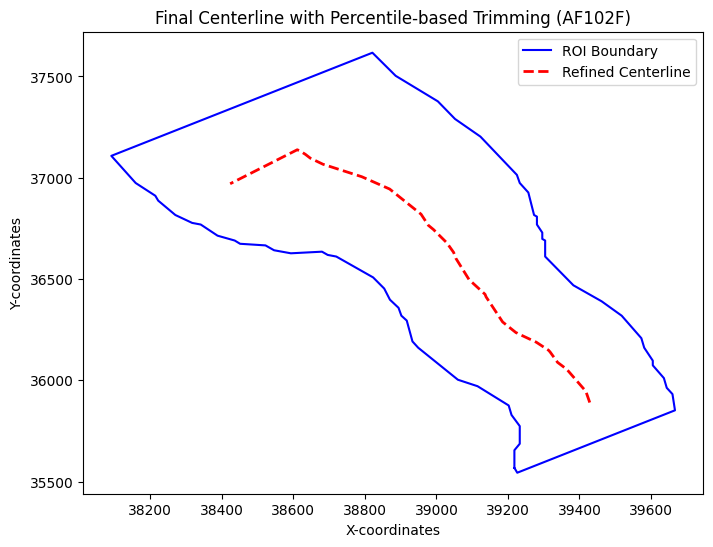

processing grayson
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 54
finding longest path
Centerline Length (after percentile trim): 3403.9119994717935
finding terminal nodes
number of terminal nodes: 35
finding longest path
Centerline Length (after percentile trim): 3250.4017138871577
Total Centerline Length: 6654.313713358952


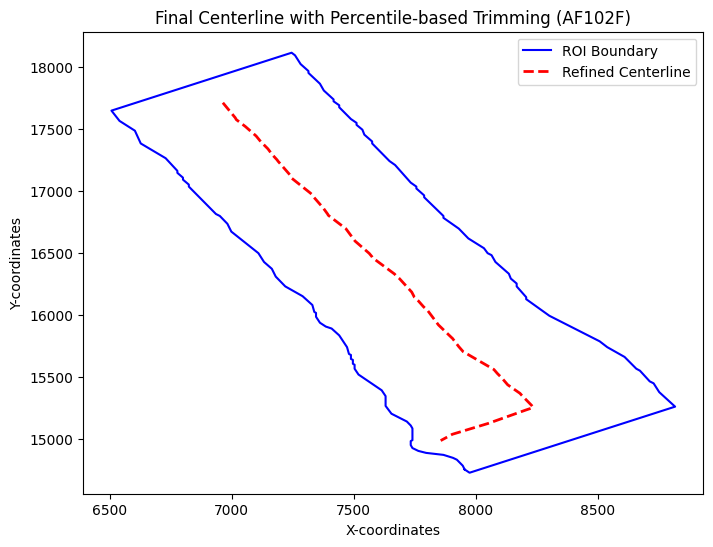

current csv file:  AH141F.csv


/tmp/ipykernel_954472/2656847302.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_centerline = pd.concat([results_centerline, new_result], ignore_index=True)


[21:03:18] WARNING  Skipping invalid ROI (ROI_4): Invalid ROI (ROI_4): ROI must contain at least 4 coordinates.

processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
finding terminal nodes
number of terminal nodes: 135
finding longest path
Centerline Length (after percentile trim): 2

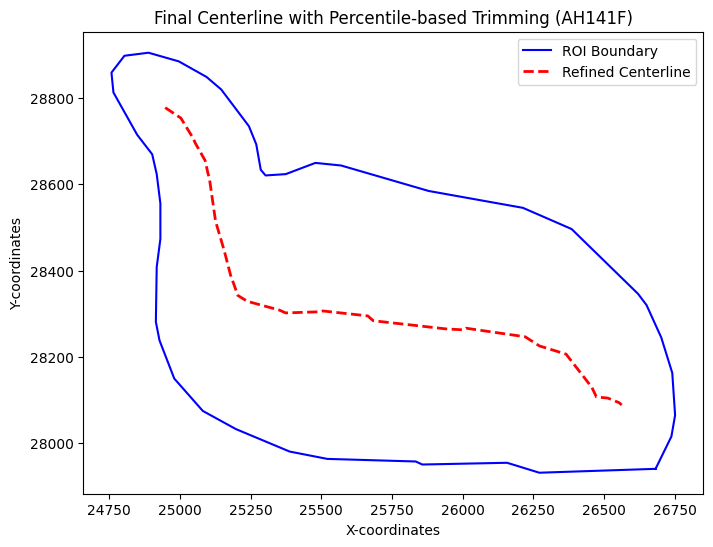

processing grayson
label being processed:  Moderate
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
label being processed:  Severe
label being processed:  Severe
label being processed:  Severe
finding terminal nodes
number of terminal nodes: 21
finding longest path
Centerline Length (after percentile trim): 2861.5334422581354
finding terminal nodes
number of t

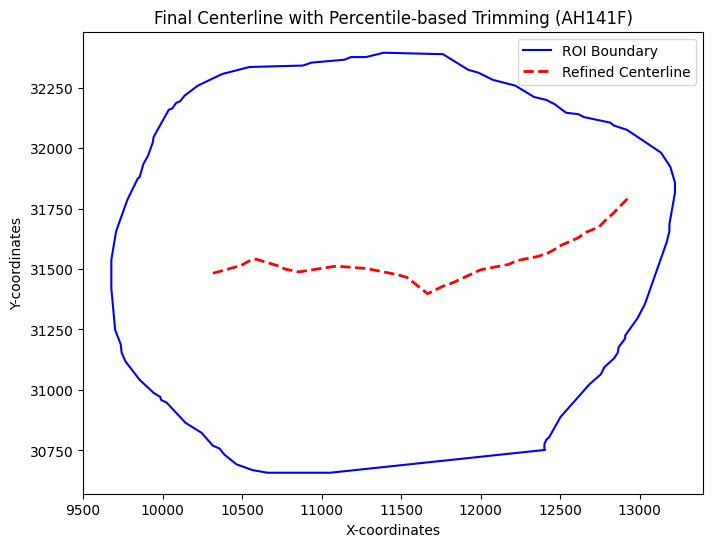

current csv file:  AF252.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 249
finding longest path
Centerline Length (after percentile trim): 15405.68096901775
finding terminal nodes
number of terminal nodes: 51
finding longest path
Centerline Length (after percentile trim): 5552.589059196986
finding terminal nodes
number of terminal nodes: 13
finding longest path
Centerline Length (after percentile trim): 5

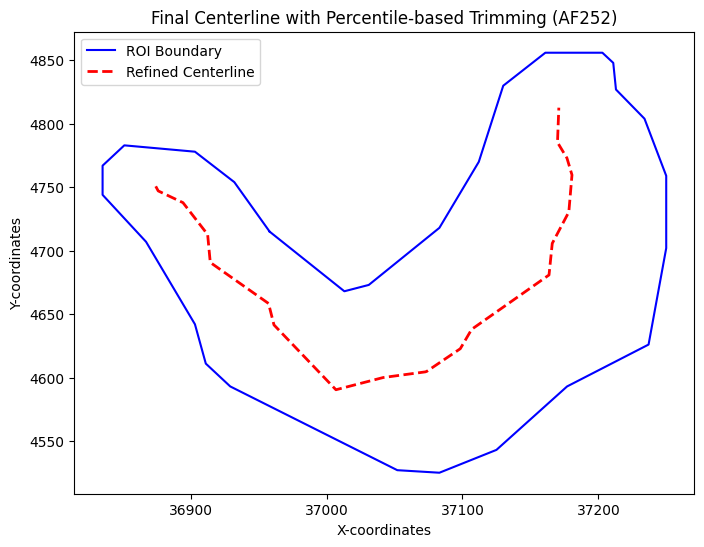

processing grayson
label being processed:  Moderate
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 59
finding longest path
Centerline Length (after percentile trim): 3777.3668791705986
finding terminal nodes
number of terminal nodes: 35
finding longest path
Centerline Length (after percentile trim): 2433.6595965433066
Total Centerline Length: 6211.026475713905


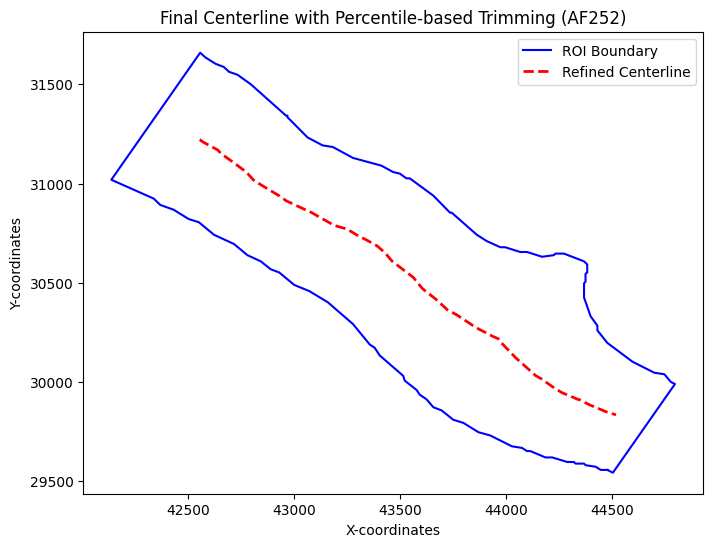

current csv file:  AF110F.csv
not running AF110F, skipping.
current csv file:  AG991M.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
finding terminal nodes
number of terminal nodes: 152
finding longest path
Centerline Length (after percentile trim): 13963.5957436

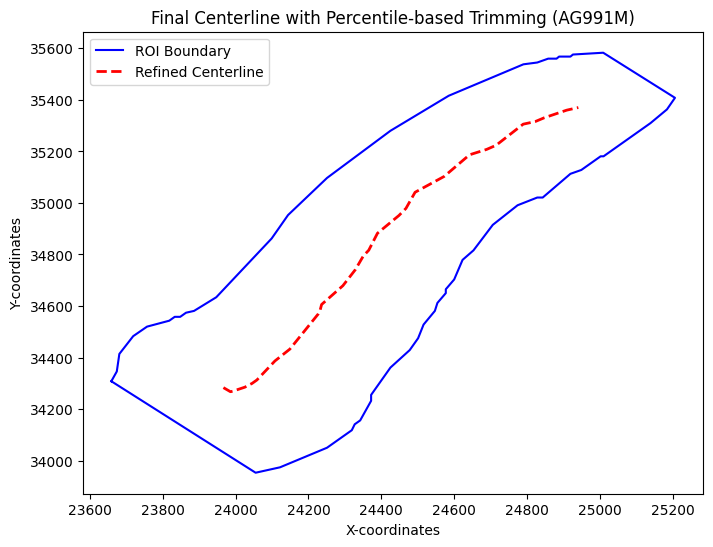

processing grayson
label being processed:  Severe
label being processed:  Severe
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label None
Unknown geometry type: Polygon for ROI with label Carcinoma
finding terminal nodes
number of terminal nodes: 18
finding lon

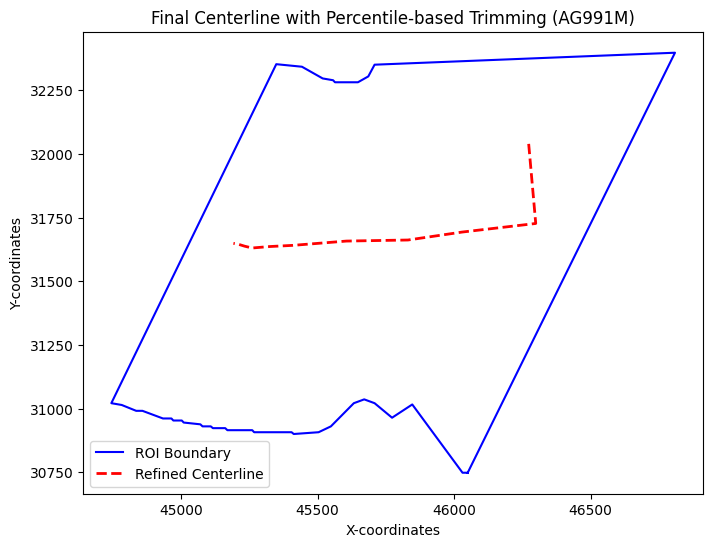

current csv file:  AH073M.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 200
finding longest path
Centerline Length (after percentile trim): 18702.31129226981
finding terminal nodes
number of terminal nodes: 127
finding longest path
Centerline Length (after percentile trim): 10584.373855385436
finding terminal nodes
number of terminal node

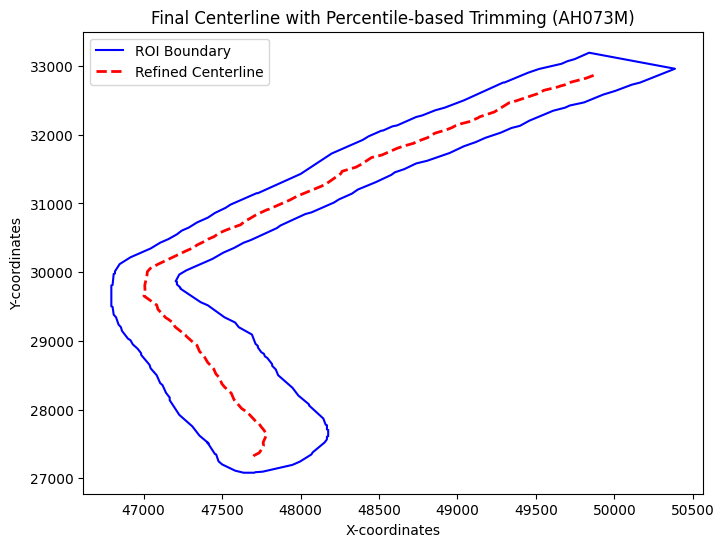

processing grayson
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown

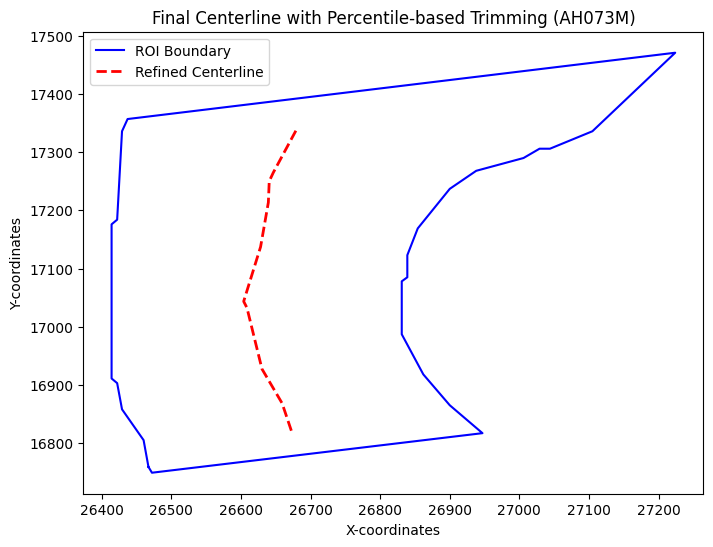

current csv file:  AF135M.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 65
finding longest path
Centerline Length (after percentile trim): 4975.153656705715
finding terminal nodes
number of terminal nodes: 52
finding longest path
Centerline Length (after percentile trim): 3506.8635023406955
finding terminal nodes
number of terminal nodes: 24
finding longest path
Centerline Length (after percentile trim): 1700.4650200184142
finding terminal nodes
number of terminal nodes: 23
finding longest path
Centerline Length (after percentile trim): 1364.54687414

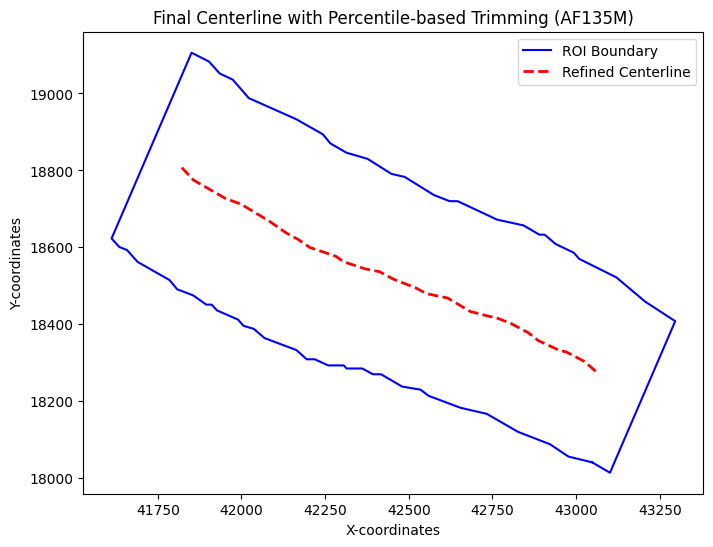

processing grayson
label being processed:  Mild
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 42
finding longest path
Centerline Length (after percentile trim): 3320.747069283761
finding terminal nodes
number of terminal nodes: 27
finding longest path
Centerline Length (after percentile trim): 2085.1385062835343
finding terminal nodes
number of terminal nodes: 22
finding longest path
Centerline Length (after percentile trim): 1250.6134207929979
Total Centerline Length: 6656.498996360294


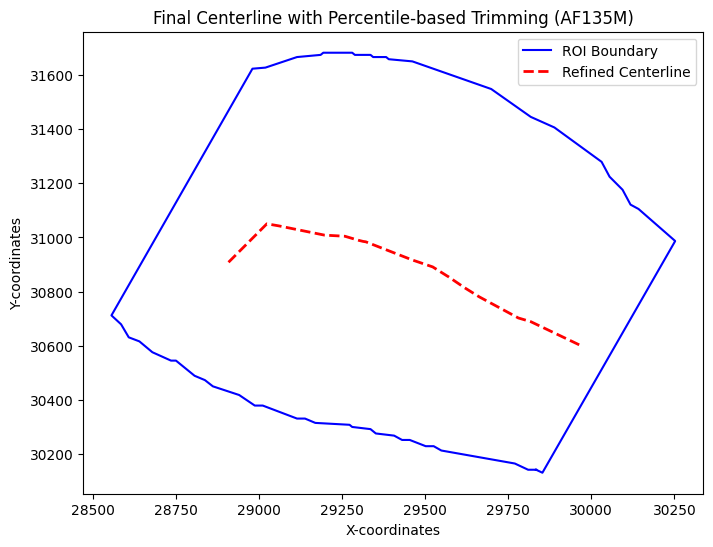

current csv file:  AG985F.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
Unknown geometry type: Polygon for ROI with label Invasive carcinoma
finding terminal nodes
number of terminal nodes: 326
finding longest path
Centerline Length (after percentile trim): 23067.23777796752
finding t

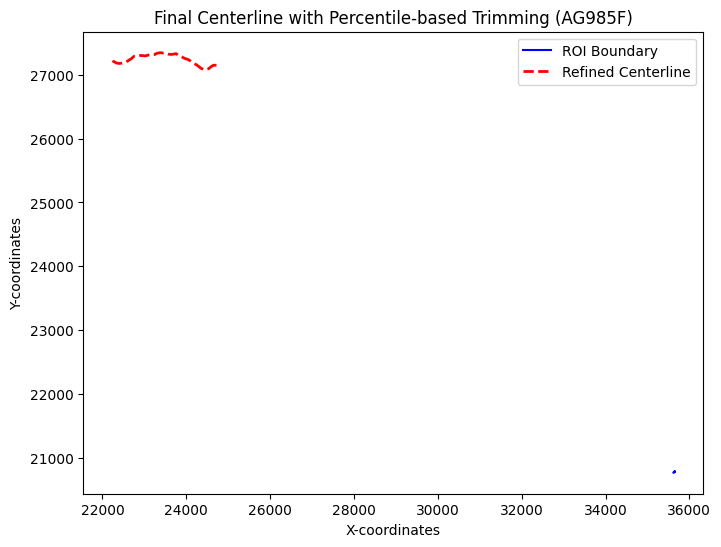

processing grayson
label being processed:  Moderate
label being processed:  Moderate
label being processed:  Moderate
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Carcinoma
Unknown geometry type: Polygon for ROI with label Carcinoma
label being processed

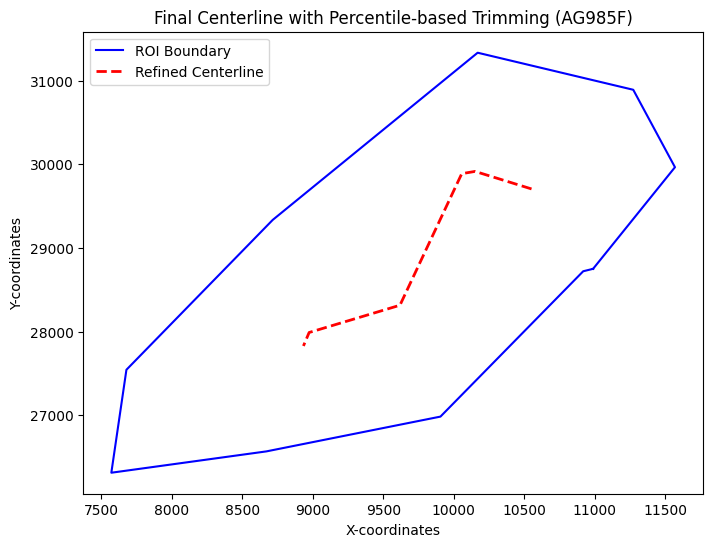

current csv file:  AF254F.csv
not running AF254F, skipping.
current csv file:  AH072M.csv
not running AH072M, skipping.
current csv file:  AF238F.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 163
finding longest path
Centerline Length (after percentile trim): 10973.957294713073
finding terminal nodes
number of terminal nodes: 31
finding longest path
Centerline Length (after percentile trim): 6738.617161307108
finding terminal nodes
number of terminal nodes: 14
finding longest path
Centerline Length (after percentile trim): 1292.0276768765498
Total Centerline Length: 19004.602132896733


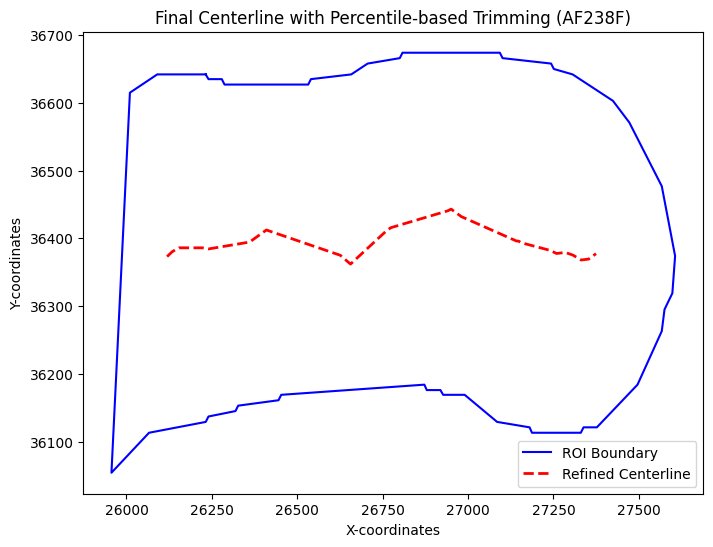

processing grayson
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 41
finding longest path
Centerline Length (after percentile trim): 1966.6374884571926
finding terminal nodes
number of terminal nodes: 39
finding longest path
Centerline Length (after percentile trim): 2189.415395045729
Total Centerline Length: 4156.052883502922


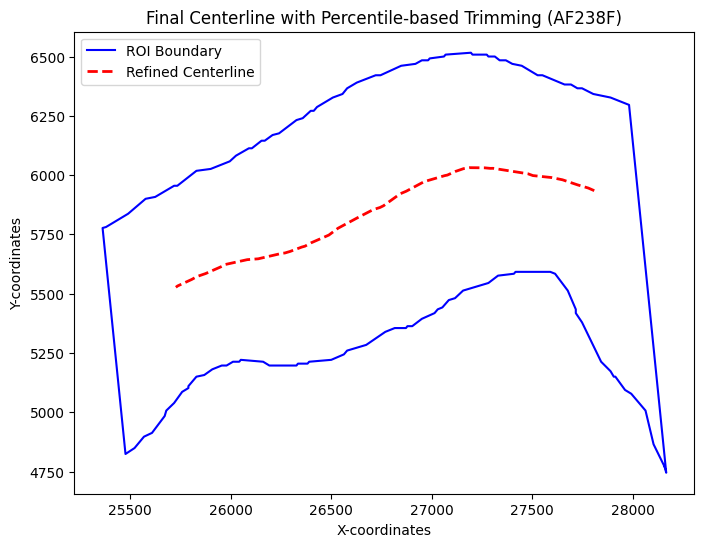

current csv file:  AF113M.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 75
finding longest path
Centerline Length (after percentile trim): 5842.5091692058295
finding terminal nodes
number of terminal nodes: 83
finding longest path
Centerline Length (after percentile trim): 4189.818160498984
Total Centerline Length: 10032.327329704814


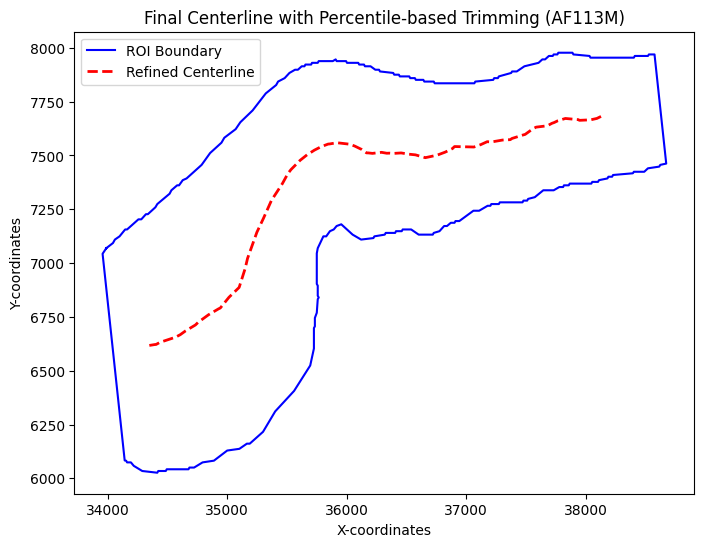

processing grayson
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Hyperkeratosis
finding terminal nodes
number of terminal nodes: 35
finding longest path
Centerline Length (after percentile trim): 2665.711714039177
Total Centerline Length: 2665.711714039177


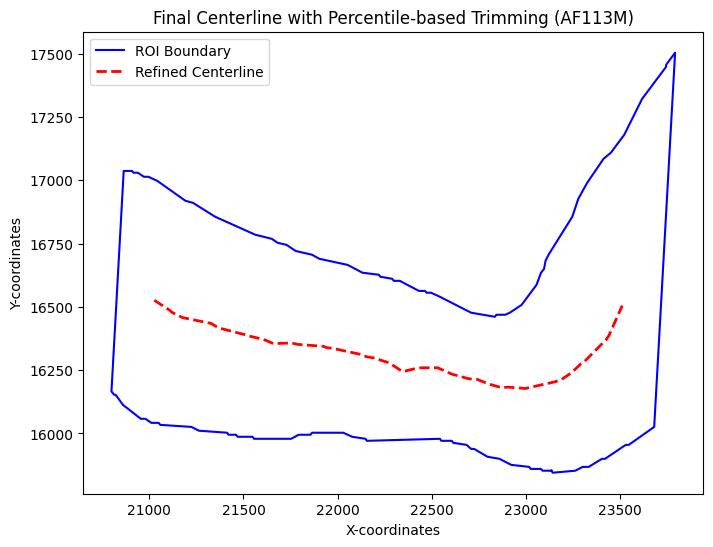

current csv file:  AF136M.csv
processing anna
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
label being processed:  Dysplasia
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
finding terminal nodes
number of terminal nodes: 81
finding longest path
Centerline Length (after percentile trim): 5571.773195867526
finding terminal nodes
number of terminal nodes: 52
finding longest path
Centerline Length (after percentile trim): 2996.0592131139624
finding terminal nodes
number of terminal nodes: 40
finding longest path
Centerline Length (after percentile trim): 2512.605214857315
finding terminal nodes
number of terminal nodes: 13
finding longest path
Centerline Length (after percentile trim): 887.2661630864258
Total Centerline Length: 11967.703786925229


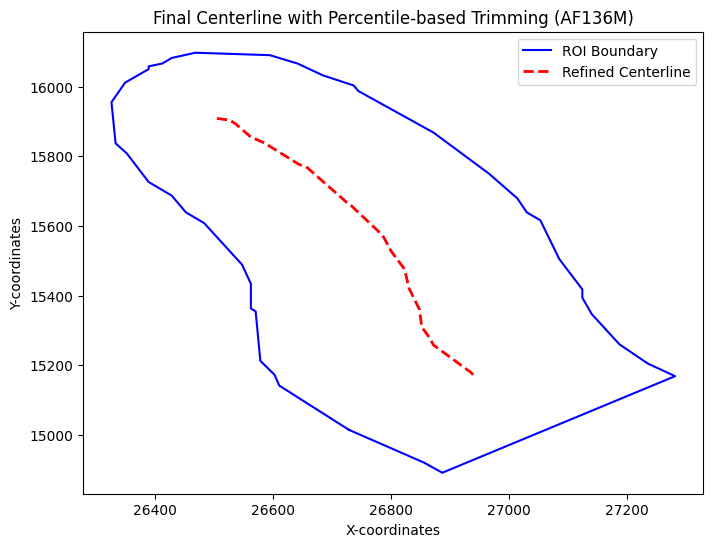

processing grayson
label being processed:  Mild
label being processed:  Mild
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Benign
Unknown geometry type: Polygon for ROI with label Hyperkeratosis
finding terminal nodes
number of terminal nodes: 46
finding longest path
Centerline Length (after percentile trim): 2743.175339614768
finding terminal nodes
number of terminal nodes: 11
finding longest path
Centerline Length (after percentile trim): 910.9865468443031
Total Centerline Length: 3654.161886459071


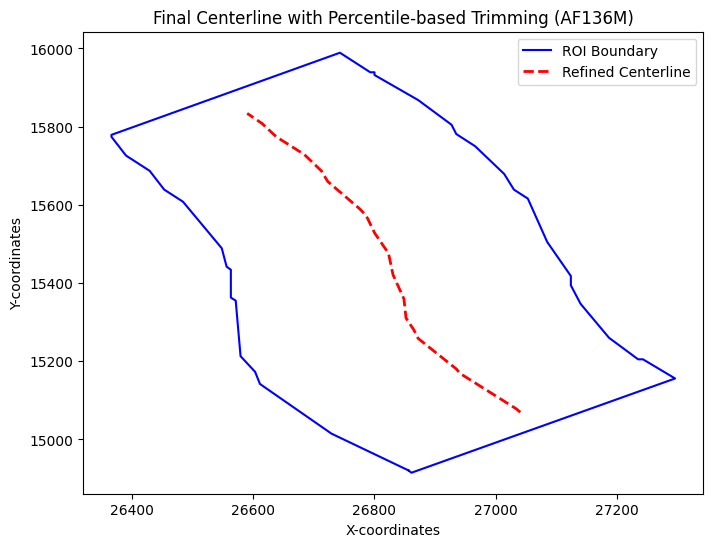

current csv file:  AG986F.csv
not running AG986F, skipping.
current csv file:  AF130F.csv
not running AF130F, skipping.
current csv file:  AG987F.csv
not running AG987F, skipping.
current csv file:  AF107.csv
not running AF107, skipping.
current csv file:  AF239F.csv
not running AF239F, skipping.
current csv file:  AF257M.csv
not running AF257M, skipping.
current csv file:  AF109.csv
not running AF109, skipping.
current csv file:  AH139F.csv
not running AH139F, skipping.
current csv file:  AF104.csv
not running AF104, skipping.
current csv file:  AH063F.csv
not running AH063F, skipping.
current csv file:  AH074M.csv
not running AH074M, skipping.


In [81]:

results_centerline = pd.DataFrame(columns=["slide", "anna_centerline_length", "grayson_centerline_length"])

grayson_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson"
anna_dir = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna"

#grayson directory has the slides they BOTH labeled 
#start by only running on these 10 base names: 
base_names = ["AF102F", "AH141F", "AF252", "AG991M", "AH073M","AF135M", "AG985F", "AF238F", "AF113M", "AF136M"]
for csv_file in os.listdir(grayson_dir):
    if csv_file.endswith(".csv"):
        print("current csv file: ", csv_file)
        base_name = csv_file.replace(".csv", "")
        if base_name not in svs_map or base_name not in base_names:
            print(f"not running {base_name}, skipping.")
            continue

        svs_path = svs_map[base_name]
        grayson_csv = os.path.join(grayson_dir, csv_file)
        anna_csv =  os.path.join(anna_dir, csv_file)

        wsi_grayson = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=grayson_csv)
        wsi_anna = sf.WSI(path=svs_path, tile_px=256, tile_um=128, rois=anna_csv)

        #get centerline length for each wsi object
        print("processing anna")
        anna_centerline_length = process_wsi(wsi_anna)
        print("processing grayson")
        grayson_centerline_length = process_wsi(wsi_grayson)

        #store in df
          #output to dataframe 
        new_result = pd.DataFrame({
            "slide": [base_name],
            "anna_centerline_length": [anna_centerline_length],
            "grayson_centerline_length": [grayson_centerline_length]
        })
        results_centerline = pd.concat([results_centerline, new_result], ignore_index=True)




In [82]:
print(results_centerline)

    slide  anna_centerline_length  grayson_centerline_length
0  AF102F             8108.688163                1684.872232
1  AH141F            21584.677391                7021.832081
2   AF252             7402.816489                1572.631904
3  AG991M             8851.624524                1052.049729
4  AH073M            22114.286231                4589.702122
5  AF135M             2923.707756                1685.425546
6  AG985F            20882.279393                7345.339683
7  AF238F             4811.965260                1052.312590
8  AF113M             2540.185280                 674.958206
9  AF136M             3030.222599                 925.233790


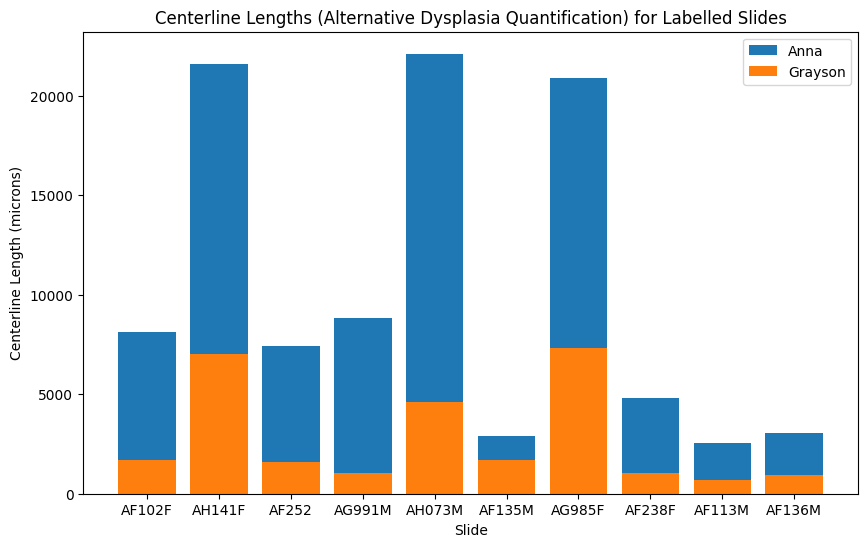

In [83]:
#make bar graph of centerline lengths for each slide 
plt.figure(figsize=(10, 6))
plt.bar(results_centerline["slide"], results_centerline["anna_centerline_length"], label="Anna")
plt.bar(results_centerline["slide"], results_centerline["grayson_centerline_length"], label="Grayson")
plt.xlabel("Slide")
plt.ylabel("Centerline Length (microns)")
plt.title("Centerline Lengths (Alternative Dysplasia Quantification) for Labelled Slides")
#add key 
plt.legend()


